In [4]:
import torch
import torchvision
from torch.optim import Adam
from PIL import Image
from torchvision import transforms
from data_utils.pre_process import load_images_from_folder, load_images_and_labels, load_datasets
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytest
from models.model_blocks import (
    UNetDecoderBlock,
    UNetEncoderBlock,
    UNetMidBlock,
    UNetDecoder,
    UNetEncoder
)
from models.unet import UNet

In [5]:
input_folder_path = "oxford-iiit-pet/images"
label_folder_path = "oxford-iiit-pet/annotations/trimaps"

input_images, label_images = load_images_and_labels(input_folder_path=input_folder_path,
                                                    label_folder_path=label_folder_path)

train_transforms = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),                  
    A.RandomCrop(height=256, width=256), 
    A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        max_pixel_value=255.0,
                        normalization="standard", # Default
                        p=1.0),
    A.ToTensorV2()                            
])

val_test_transforms = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),                  
    A.RandomCrop(height=256,width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                normalization="standard", # Default
                p=1.0),
    A.ToTensorV2()                          
])

train_dataset, val_dataset, test_dataset = load_datasets(input_images, 
                                                            label_images, 
                                                            train_transforms,
                                                            val_test_transforms,
                                                            shuffle=True,
                                                            save_path="saved_data")

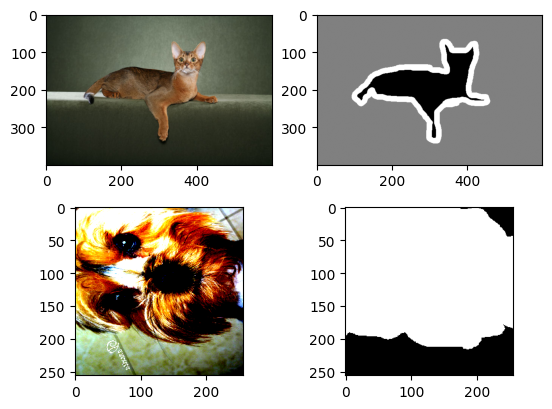

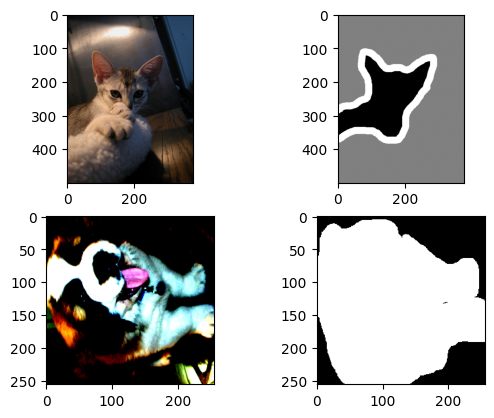

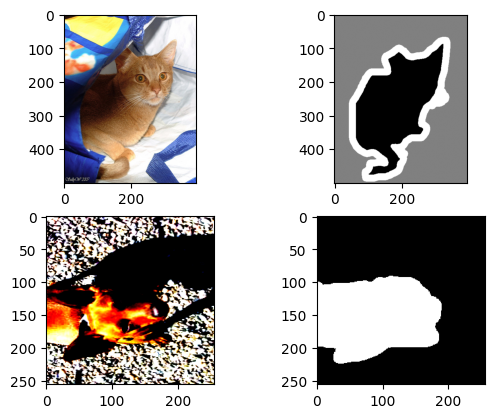

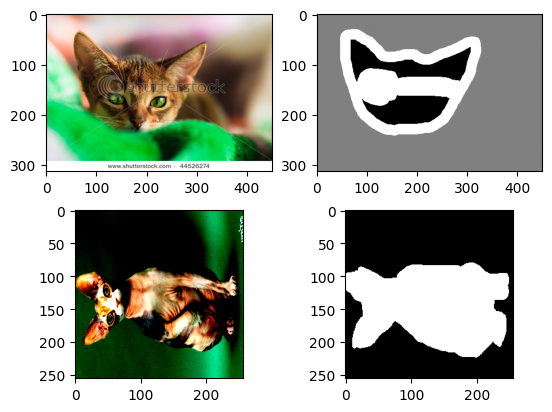

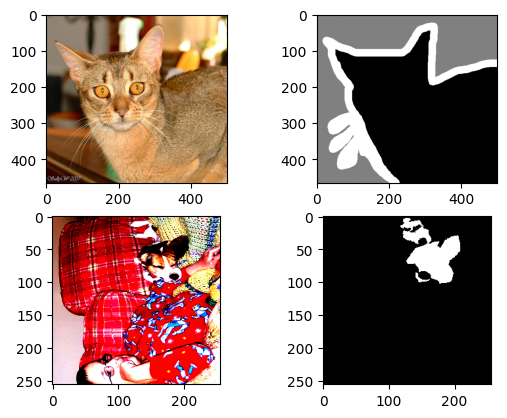

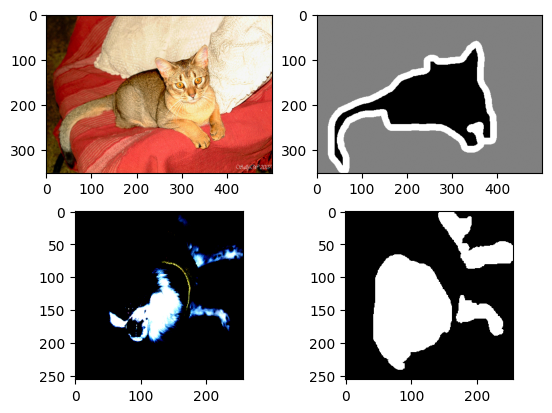

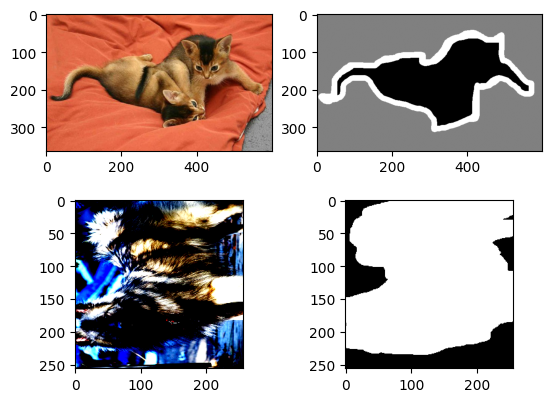

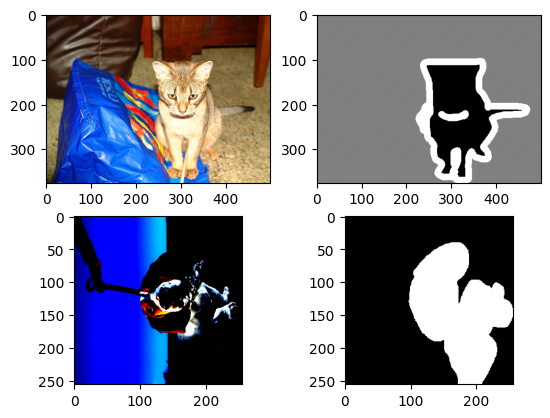

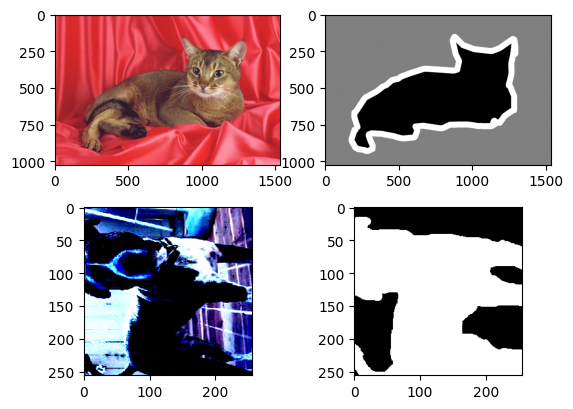

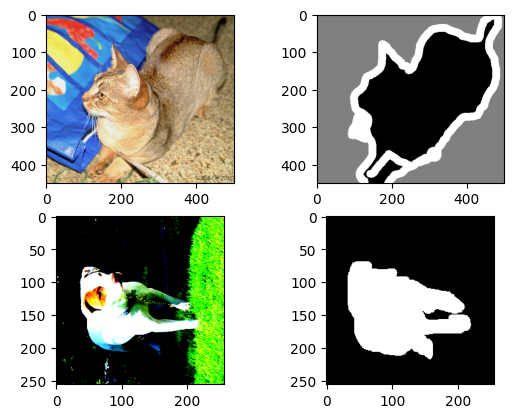

In [14]:
for i in range(10):
    fig, axes = plt.subplots(2,2)
    original_img, original_segment = input_images[i], label_images[i]
    trans_img, trans_segment = train_dataset.__getitem__(i)

    axes[0,0].imshow(original_img)
    axes[0,1].imshow(original_segment, cmap='gray')

    axes[1,0].imshow(np.clip(trans_img.T, 0, 1))
    axes[1,1].imshow(trans_segment.T, cmap='grey')

    plt.show()
    

In [6]:
from torch.utils.data import DataLoader
train_datalaod = DataLoader(train_dataset, batch_size=8)

In [15]:
x_batch, y_batch = next(iter(train_datalaod))

In [16]:
unet = UNet(in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            final_filters=1,
            encoder_dropout=0)

# x = torch.unsqueeze(x, 0)
y_hat = unet(x_batch)

In [17]:
y_hat.shape

torch.Size([8, 1, 256, 256])

In [19]:
y_batch

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [13]:
l = torch.nn.BCEWithLogitsLoss()

In [14]:
l(y_hat, y_batch)

tensor(0.6995, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [37]:
torch.unsqueeze(torch.unsqueeze(y, dim = 0), dim = 0)

torch.Size([1, 1, 256, 256])

In [1]:
import yaml
def load_sweep_config(path: str):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [2]:
k = load_sweep_config("sweep/sweep_config.yaml")

In [9]:
k

{'program': 'model_sweep.py',
 'name': 'unet-image-segmentation-sweep',
 'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'learning_rate': {'min': 0.0001, 'max': 0.1},
  'batch_size': {'values': [16, 32, 64, 128]},
  'epochs': {'values': [100]},
  'out_channels': {'values': [16, 32, 64, 128]}}}